# I. Training mô hình

<b>Trong phần này sẽ tiến hành với 3 nhiệm vụ chính:</b><br><br>
&emsp; ⮚ [Chuẩn hóa dữ liệu](#3.-Chuẩn-hóa-dữ-liệu) <br>
&emsp; ⮚ [Xây dựng mô hình cho bài toán](#2.-Định-nghĩa-các-mô-hình-cho-bài-toán)<br>
&emsp; ⮚ [Tiến hành traning và đánh giá các mô hình](#3.-Chuẩn-hóa-dữ-liệu)<br>

In [20]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\tools")

import common.config as cf
import common.utils as utl
import seaborn as sns

### Khai báo biến sử dụng

In [2]:
path_data_raw = '../tools/data_train/data_phongtro123_data.csv'
path_data_train = '../tools/roomdata.csv'

random_state = 14

path_model_folder = '../tools/'

### 1. Định nghĩa các hàm biểu diễn

In [22]:
# Biểu đồ giá trị thực tế và giá dự báo dạng đường
def show_actual_and_predict(y_test, y_pred):
    actual_list = y_test.tolist()
    predict_list = y_pred.tolist()
    index_list = list(range(1, len(actual_list)+1))

    plt.plot(index_list, actual_list, label='Thực tế', linewidth=2)
    plt.plot(index_list, predict_list, label='Dự báo', linewidth=2)

    plt.xlabel('Mẫu thử nghiệm')
    plt.ylabel('Giá phòng')
    plt.legend(loc='upper left')
    plt.xticks(index_list)
    plt.title('Giá phòng thực tế và dự báo')
    plt.show()

In [4]:
# Hiển thị thông tin đánh giá mô hình dự trên y actual và y prediction
def print_test_infor(y_test, y_pred):
    print('MAE     :', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE     :', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE    :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE    :', utl.mape(y_test, y_pred))
    print('VarScore:', metrics.explained_variance_score(y_test, y_pred))

In [5]:
# Biểu đồ thể hiện biên độ giao động giá thực tế và giá dự đoán
def show_residual_actual_and_predict(y_test, y_pred):
    diff = y_test - y_pred
    index_list = list(range(1, len(y_test) + 1))
    plt.plot(index_list, diff, label='Số dư', linewidth=2)
    plt.title('Sự chênh lệnh giá phòng và dự đoán')  # Plot heading
    plt.xlabel('Index', fontsize=16)  # X-label
    plt.ylabel('Thực tế- Dự đoán', fontsize=16)  # Y-label
    plt.show()

In [6]:
# Biểu đồ sự chênh lệnh giá và tần suất
def show_residual_and_frequency(y_test, y_pred):
    sns.distplot(y_test - y_pred)
    plt.title("Biểu đồ tần suất và chênh lệch")
    plt.xlabel("Chênh lệch")
    plt.ylabel("Tần suất")
    plt.show()

### 2. Định nghĩa các mô hình cho bài toán

In [7]:
# Mô hình mạng MLP (Multilayer Perceptron) - Deep learning
def multiple_layer_perceptron_regression(X_train, y_train, X_test, y_test, factor=1,
                                         show_infor=True,
                                         save_model=False):
    neural_number = X_train.shape[1] * factor
    MLP = Sequential([
        Dense(neural_number, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(neural_number, activation='relu'),
        Dense(neural_number, activation='relu'),
        Dense(neural_number, activation='relu'),
        Dense(1)
    ])

    MLP.compile(optimizer='adam', loss='mean_squared_error')
    history = MLP.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                        batch_size=30, epochs=600, verbose=0)

    y_pred = MLP.predict(X_test)
    y_pred = y_pred.flatten()

    if save_model:
        utl.save_model(MLP, path_model_folder+cf.cf_model_mlp['path'])

    if show_infor:
        show_actual_and_predict(y_test, y_pred)
        show_residual_actual_and_predict(y_test, y_pred)
        # utl.show_history(history)
        show_residual_and_frequency(y_test, y_pred)
        print_test_infor(y_test, y_pred)

In [8]:
# Mô hình Multiple Linear Regression
def linear_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=False):
    ML = LinearRegression()
    ML.fit(X_train, y_train)

    y_pred = ML.predict(X_test)
    rmse = utl.mape(y_test, y_pred)

    if save_model:
        utl.save_model(ML, path_model_folder+cf.cf_model_mlinear['path'])

    if show_infor:
        show_actual_and_predict(y_test, y_pred)
        show_residual_actual_and_predict(y_test, y_pred)
        # utl.show_history(history)
        show_residual_and_frequency(y_test, y_pred)
        print_test_infor(y_test, y_pred)
    return rmse

In [9]:
# Mô hình k-Nearest Neighbors Regression
def knn_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=False):
    # Thiết lập set n hàng xóm
    KNN = KNeighborsRegressor(n_neighbors=5, weights='distance')
    KNN.fit(X_train, y_train)

    y_pred = KNN.predict(X_test)

    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    if save_model:
        utl.save_model(KNN, path_model_folder+cf.cf_model_knn['path'])

    if show_infor:
        show_actual_and_predict(y_test, y_pred)
        show_residual_actual_and_predict(y_test, y_pred)
        show_residual_and_frequency(y_test, y_pred)
        print_test_infor(y_test, y_pred)
    return rmse

In [10]:
# Mô hình Random Forest Regression
def random_forest_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=False):
    RF = RandomForestRegressor(n_estimators=1000, random_state=random_state)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_test)

    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    if save_model:
        utl.save_model(RF, path_model_folder+cf.cf_model_randf['path'])

    if show_infor:
        show_actual_and_predict(y_test, y_pred)
        show_residual_actual_and_predict(y_test, y_pred)
        show_residual_and_frequency(y_test, y_pred)
        print_test_infor(y_test, y_pred)
    return rmse

### 3. Chuẩn hóa dữ liệu 

Do tính chất chu kỳ của tháng nên ta sẽ tách cột <b>thang</b> thành 2 cột <b>thang_sin</b> , <b>thang_cos</b>

In [11]:
# Encoder cột tháng có tính chất chu kỳ
def MonthEncoder(df):
    df.insert(df.columns.get_loc(cf.col_thang), cf.col_thang+'_sin', np.sin(2 * np.pi * df[cf.col_thang]/12))
    df.insert(df.columns.get_loc(cf.col_thang), cf.col_thang+'_cos', np.cos(2 * np.pi * df[cf.col_thang]/12))
    df.drop([cf.col_thang], axis='columns', inplace=True)

In [12]:
def preprocessing_data(df, save=False):
    # "giuongtu","banghe","nonglanh","dieuhoa","tulanh","maygiat","tivi","bep","gacxep","thangmay","bancong","chodexe"
    col_cate_hot   = []                                               # không thứ tự không ảnh hưởng trọng số
    col_cate_ori   = [['loai',  ['Nhacap','Nhatang','Ccmn']],
                      ['loaiwc',['KKK','Khepkin'          ]]]         # có thứ tự : cold warm, hot
    col_cate_lab   = []                                               # dùng cho cate không có thứ tự
    col_standard   = ["dientich","vido","kinhdo","drmd","kcdc"]
    col_normal     = ["nam"]

    # Chuẩn hóa trường tháng có tính chất chu kỳ
    MonthEncoder(df)

    # categories label: Dành cho danh mục tính liệt kê vẫn ảnh có ảnh hưởng thứ tự
    for col_name in col_cate_lab:
        enc = preprocessing.LabelEncoder()
        df[col_name] = enc.fit_transform(df[[col_name]])

    # categories label : Danh cho danh mục không ảnh tính độc lập
    for col_name in col_cate_hot:
        hot = preprocessing.OneHotEncoder()
        oe_results = hot.fit_transform(df[[col_name]]).toarray()
        ohe_df = pd.DataFrame(oe_results, columns=hot.get_feature_names([col_name]))
        pd.concat([df, ohe_df], axis=1)
        df.drop([col_name], axis='columns', inplace=True)

    # categories ori : Dành cho danh sách có tính mức độ cấp độ
    # df['loai'] = df['loai'].map({'Nhacap':1,'Nhatang': 2,'Ccmn': 3})
    # df['loaiwc'] = df['loaiwc'].map({'KKK':1,'Khepkin': 2})
    for col_name in col_cate_ori:
        ori = preprocessing.OrdinalEncoder(categories=[col_name[1]])
        df[col_name[0]] = ori.fit_transform(df[[col_name[0]]])
        if save:
            utl.save_encoder(ori, cf.path_folder_encoder + col_name[0] + '_enc.pkl')

    # standardize : Thường dành cho các trường phân phối chuẩn
    for col_name in col_standard:
        stan = preprocessing.StandardScaler()
        df[col_name] = stan.fit_transform(df[[col_name]])
        if save:
            utl.save_encoder(stan, cf.path_folder_encoder + col_name + '_enc.pkl')

    # normalize :  Dành cho nhưng trường phân phối không chuẩn
    for col_name in col_normal:
        norm = preprocessing.MinMaxScaler()
        df[col_name] = norm.fit_transform(df[[col_name]])
        if save:
            utl.save_encoder(norm, cf.path_folder_encoder + col_name + '_enc.pkl')

### 4. Load dữ liệu và train mô hình 

In [24]:
df = pd.read_csv(path_data_train)

In [27]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,nam,thang,giaphong,dientich,vido,kinhdo,drmd,kcdc,giuongtu,banghe,nonglanh,dieuhoa,tulanh,maygiat,tivi,bep,gacxep,thangmay,bancong,chodexe
count,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000,982.00000
mean,2019.77393,5.81161,2703746.43483,24.24949,21.01760,105.80982,3.71219,99.83070,0.66701,0.27800,0.60591,0.59674,0.18330,0.26986,0.04379,0.41446,0.10896,0.12424,0.30652,0.61100
std,1.48104,3.43813,1006934.77963,8.90924,0.02876,0.02868,1.85942,103.02667,0.47152,0.44824,0.48890,0.49080,0.38711,0.44411,0.20473,0.49288,0.31175,0.33002,0.46128,0.48777
min,2016.00000,1.00000,500000.00000,8.00000,20.93351,105.73281,1.60000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,2019.00000,3.00000,2000000.00000,18.00000,20.99376,105.78737,2.50000,35.35500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,2020.00000,4.00000,2600000.00000,24.50000,21.01654,105.80961,3.20000,75.40000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
75%,2021.00000,8.00000,3287500.00000,30.00000,21.03764,105.82514,4.00000,129.19500,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000
max,2021.00000,12.00000,6950000.00000,65.00000,21.08907,105.93772,14.50000,800.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [14]:
preprocessing_data(df, save=False)
X = df.drop(['giaphong'], axis=1).values
y = df['giaphong'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

[OF] Model saving...to file ../tools/models/mlinear_room_prediction.h5 => OK


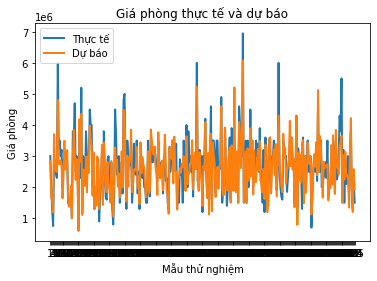

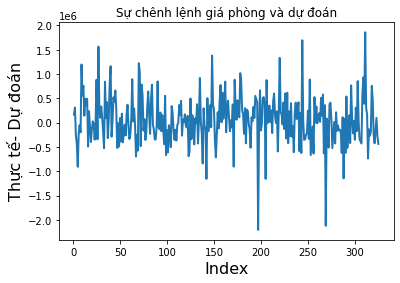

C:\Users\DesertFoxee\anaconda3\envs\room_api\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


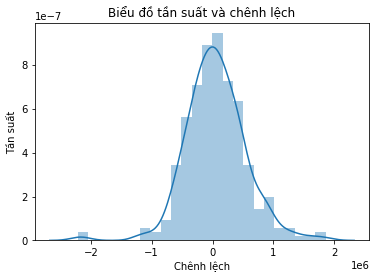

MAE     : 367493.11451973254
MSE     : 246275501654.4173
RMSE    : 496261.5254625501
MAPE    : 14.534055042850854
VarScore: 0.7287684954719567


14.534055042850854

In [16]:
linear_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=True)


[OF] Model saving...to file ../tools/models/knn_room_prediction.h5 => OK


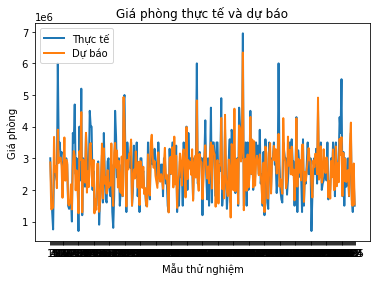

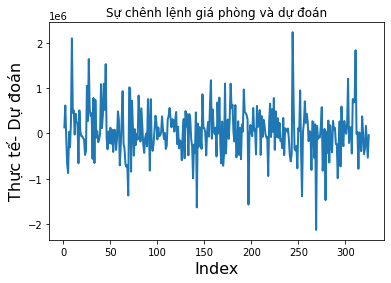

C:\Users\DesertFoxee\anaconda3\envs\room_api\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


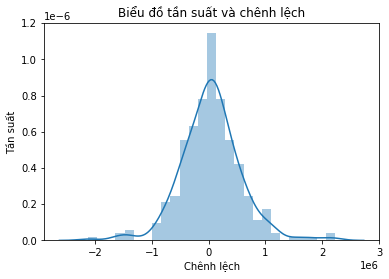

MAE     : 388379.13078925526
MSE     : 285990985496.14813
RMSE    : 534781.250135182
MAPE    : 16.167105801051353
VarScore: 0.683005128796246


534781.250135182

In [17]:
knn_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=True)

[OF] Model saving...to file ../tools/models/randf_room_prediction.h5 => OK


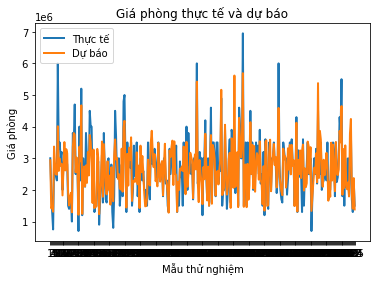

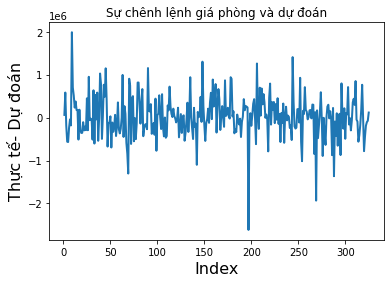

C:\Users\DesertFoxee\anaconda3\envs\room_api\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


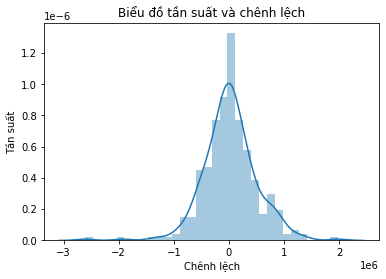

MAE     : 349362.92009846156
MSE     : 238570088018.4655
RMSE    : 488436.3704910451
MAPE    : 13.96563997485549
VarScore: 0.7345670359591594


488436.3704910451

In [18]:
random_forest_regressions(X_train, y_train, X_test, y_test, show_infor=True, save_model=True)

[OF] Model saving...to file ../tools/models/mlp_room_prediction.h5 => Failed


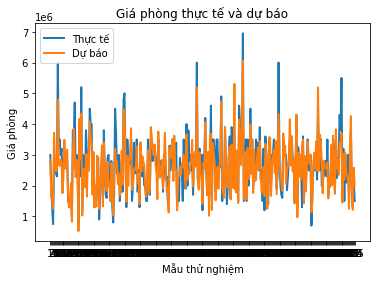

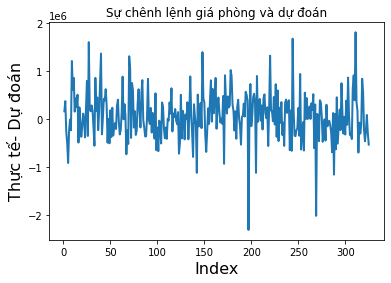

C:\Users\DesertFoxee\anaconda3\envs\room_api\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


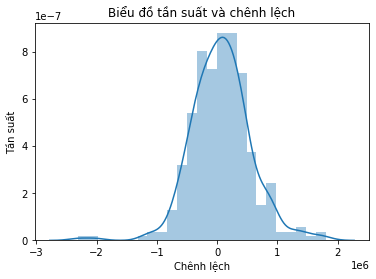

MAE     : 373286.5003846154
MSE     : 250459186238.85162
RMSE    : 500458.97558026836
MAPE    : 14.89481981668686
VarScore: 0.7257222853238596


In [19]:
multiple_layer_perceptron_regression(X_train, y_train, X_test, y_test, show_infor=True, save_model=True)